# Synchornization in complete networks of neurons
Here is the dynamics of neurons potentails in rotational model :
$$
\begin{cases}
\dot{\theta_i}=I_i - cos(\theta_i) +  E \\
\ddot{E}+ 2\alpha \dot{E}+\alpha^{2}E =\frac{\alpha^{2}}{N} \sum_{n|tـn<t} \delta(t - t_n - t_d)
\end{cases}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
num_neurons = 1000
g =  2
random_input_span = (3.5,13.5) #it should fall in the well defined cos(\theta) domain.

total_time = 1000
time_step = 0.01
total_steps = int(total_time/time_step)
time_span = np.arange(0,total_time,time_step)

delay_time = 0.1
delay_step = int(delay_time/time_step)

alpha = 20
m_arr = np.zeros(total_steps)
e_arr = np.zeros(total_steps)

theta_arr = np.zeros(num_neurons,dtype = float)
# theta_arr = np.random.uniform(0,2*np.pi,size = num_neurons)
random_input = np.random.uniform(*random_input_span,size = num_neurons)

In [3]:
spiking_records = np.array( np.zeros((total_steps,num_neurons)), dtype = bool )
amin_saman_param = np.zeros( total_steps )

## Instrumentes to capture spiking frequency
Here we use *cornometer* and number of spikies to measure their frequencies.

In [4]:
spiking_cornometer = np.zeros(num_neurons)
total_spikes_intervals = np.zeros(num_neurons)
total_spikes_num = np.zeros(num_neurons)

In [5]:
def retarded_spikes_record(step):
    """
    This is the function which take cares of response delay between spikes and their effects.
    """
    if step > delay_step: 
        return np.sum(spiking_records[step - delay_step])
    else:
        return 0


## "For" loop on the march!
To make equations more solvable we turn them into three cases of linear first order equations:
$$
\begin{cases}
\dot{\theta_i}=I_i - cos(\theta_i) - g E \\
\dot{E} = M - \alpha E\\
\dot{M} = -  \alpha M + \frac{ \alpha^{2} }{N} \sum_{n|tـn<t} \delta(t - t_n - t_d)
\end{cases}
$$

In [6]:
for i in tqdm( range(total_steps - 1) ):
    theta_arr = theta_arr + (random_input - np.cos(theta_arr) - g * e_arr[i] )*time_step
    
    #here we should spot the spiking neurons.
    spiking_records[i] = theta_arr > np.pi
    theta_arr = theta_arr - 2 * np.pi * spiking_records[i]
    #neurons activity
    m_arr[i+1] = m_arr[i] + time_step*( -alpha*m_arr[i] ) + ( (alpha**2)/num_neurons ) *retarded_spikes_record(i) 
    e_arr[i+1] = e_arr[i] + time_step*( m_arr[i] - alpha*e_arr[i] )
    #
    left_handed_neurons = np.cos(theta_arr) < 0
    amin_saman_param[i] = np.mean( np.sin(theta_arr[left_handed_neurons]) )**2
    #frequency calculator
    total_spikes_num = total_spikes_num + spiking_records[i]
    total_spikes_intervals = total_spikes_intervals + spiking_cornometer * spiking_records[i] #add to spike lapsed time
    spiking_cornometer = spiking_cornometer * (spiking_records[i]-1)*(-1) #reset the spikied cornos
    spiking_cornometer = spiking_cornometer + (spiking_records[i]-1)*(-1) #update the not spikied ones
    
    

  0%|                                                                                        | 0/99999 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████████████| 99999/99999 [00:08<00:00, 12205.08it/s]


In [7]:
sigma = np.std( e_arr )
sigma

0.07724485067712351

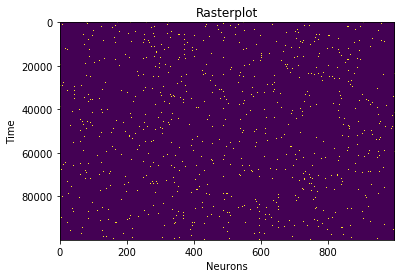

In [8]:
plt.imshow( spiking_records,aspect= 'auto')
plt.xlabel('Neurons')
plt.ylabel('Time')
plt.title('Rasterplot')
plt.savefig('raster_plot_N{}_g{}.png'.format(num_neurons,g))

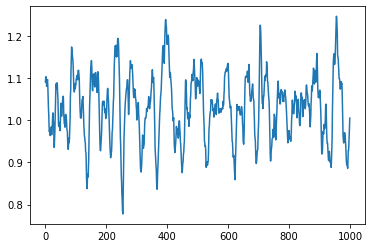

In [9]:
plt.plot(e_arr[-1000:])

(array([ 95., 100.,  84.,  99., 130., 126., 110.,  91.,  84.,  81.]),
 array([-3.13615261, -2.51038623, -1.88461986, -1.25885348, -0.6330871 ,
        -0.00732073,  0.61844565,  1.24421203,  1.8699784 ,  2.49574478,
         3.12151116]),
 <a list of 10 Patch objects>)

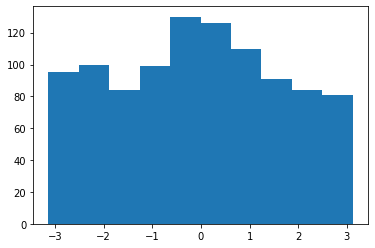

In [10]:
plt.hist(theta_arr )

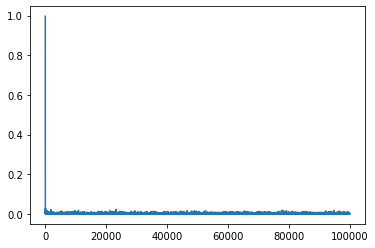

In [11]:
plt.plot(amin_saman_param)

In [12]:
np.mean(amin_saman_param[-100:])

0.0014592433668066467

## Calculate frequnecy

In [15]:
spikies_period_mean = total_spikes_intervals * time_step / total_spikes_num
spikies_period_mean

array([1.67419899, 0.92479888, 1.25518987, 0.8931075 , 0.96378168,
       0.55232283, 0.69822821, 0.73193022, 0.59876979, 0.63811933,
       1.27726804, 1.74201754, 4.92514851, 0.9707262 , 1.93309339,
       1.02948025, 0.55396503, 0.75873077, 1.35305593, 1.50087746,
       1.7414386 , 1.19255114, 0.66629229, 0.71870262, 2.08014644,
       1.30141732, 1.65951505, 0.85947826, 2.41997567, 2.00237903,
       0.96226654, 0.58665274, 0.55481921, 0.5647069 , 1.45561584,
       0.61826524, 1.87320151, 1.01464615, 1.21169927, 1.02954214,
       1.4341185 , 0.97987129, 3.65536765, 0.66923234, 5.70337143,
       0.88471799, 0.7185277 , 0.572318  , 0.89615594, 4.46103139,
       3.88511719, 0.62368188, 2.69834688, 0.71677091, 2.38143541,
       2.01908537, 2.56654639, 1.16192263, 0.87283569, 2.51265152,
       1.58535144, 0.59055856, 0.55535633, 0.6111995 , 2.51012626,
       1.77303571, 1.21797297, 1.03050989, 3.37518644, 1.25253788,
       0.63790668, 2.93247788, 0.55556561, 0.97772727, 1.67127

(array([574., 185., 104.,  45.,  28.,  20.,  19.,  10.,   7.,   8.]),
 array([0.54142306, 1.08039385, 1.61936464, 2.15833542, 2.69730621,
        3.236277  , 3.77524779, 4.31421858, 4.85318937, 5.39216016,
        5.93113095]),
 <a list of 10 Patch objects>)

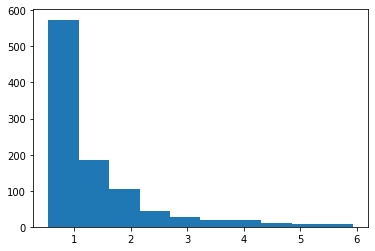

In [17]:
plt.hist(spikies_period_mean)

In [18]:
bins =  plt.hist(spikies_freq_neurons)[0]
height = plt.hist(spikies_freq_neurons)[1]
plt.scatter( bins,height)
plt.yscale('log')
plt.xscale('log')

NameError: name 'spikies_freq_neurons' is not defined

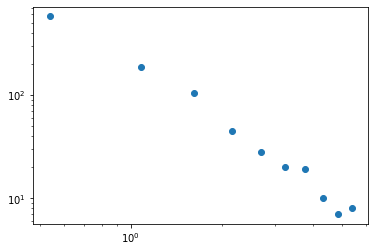

In [25]:
heights, bins = np.histogram(spikies_period_mean)
plt.scatter(bins[:-1],heights)
plt.yscale('log')
plt.xscale('log')

In [ ]:
np.mean(spikies_freq_neurons),np.var(spikies_freq_neurons)